# Novelty Methods with Audio Cursor

This notebook loads a marker segment from an audio track, computes four novelty functions (energy, spectral, phase, complex), and displays an audio player with a synchronized cursor bar for each method.

In [1]:
import json
import sys
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display

# Add project root for dijon imports (works from notebooks/scratch or project root)
project_root = Path.cwd()
if not (project_root / "src" / "dijon").exists():
    project_root = project_root.parent.parent
sys.path.insert(0, str(project_root))

from dijon.global_config import AUDIO_MARKERS_DIR, DERIVED_DIR, RAW_AUDIO_DIR
from dijon.novelty import (
    compute_novelty_complex,
    compute_novelty_energy,
    compute_novelty_phase,
    compute_novelty_spectrum,
)
from dijon.notebook_ui import build_audio_with_cursor_html, display_audio_with_cursor

%matplotlib inline

In [2]:
TRACK = "YTB-013"
MARKER = "HEAD_IN"

print(f"Track: {TRACK}  |  Marker: {MARKER}")

Track: YTB-013  |  Marker: HEAD_IN


In [3]:
# Load markers and extract segment time range
marker_prefix = MARKER.upper().replace("-", "_")
markers_path = AUDIO_MARKERS_DIR / f"{TRACK}_markers.json"
with open(markers_path) as f:
    markers_data = json.load(f)

markers = markers_data["entries"][0]["markers"]
seg_start = next(m["position"] for m in markers if m["name"] == f"{marker_prefix}_START")
seg_end = next(m["position"] for m in markers if m["name"] == f"{marker_prefix}_END")

print(f"{marker_prefix}: {seg_start:.2f}s - {seg_end:.2f}s (duration: {seg_end - seg_start:.2f}s)")
# Load full audio and extract segment
audio_path = RAW_AUDIO_DIR / f"{TRACK}.wav"
x_full, sr = librosa.load(audio_path, sr=None, mono=True)
start_sample = int(seg_start * sr)
end_sample = int(seg_end * sr)
x = x_full[start_sample:end_sample]
duration_s = len(x) / sr

print(f"Loaded segment: {len(x)} samples, {duration_s:.2f}s at {sr} Hz")

HEAD_IN: 0.20s - 31.27s (duration: 31.08s)
Loaded segment: 685269 samples, 31.08s at 22050 Hz


## Compare all novelty methods

Compute all four novelty functions, then display their players side by side for visual comparison.

In [4]:
t_wav = np.arange(len(x)) / sr

novelty_dir = DERIVED_DIR / "novelty"
novelty_dir.mkdir(parents=True, exist_ok=True)

N_eng, H_eng = 2048, 128
novelty_eng, Fs_eng = compute_novelty_energy(x, Fs=sr, N=N_eng, H=H_eng, gamma=10.0)
np.save(novelty_dir / f"{TRACK}_{MARKER}_energy.npy", novelty_eng)

N_spec, H_spec = 1024, 256
novelty_spec, Fs_spec = compute_novelty_spectrum(x, Fs=sr, N=N_spec, H=H_spec, gamma=100.0, M=10, norm=True)
np.save(novelty_dir / f"{TRACK}_{MARKER}_spectral.npy", novelty_spec)

N_phase, H_phase = 1024, 64
novelty_phase, Fs_phase = compute_novelty_phase(x, Fs=sr, N=N_phase, H=H_phase, M=10, norm=True)
np.save(novelty_dir / f"{TRACK}_{MARKER}_phase.npy", novelty_phase)

# Complex: compute -> save -> build fig -> widget
N_complex, H_complex = 1024, 64
novelty_complex, Fs_complex = compute_novelty_complex(
    x, Fs=sr, N=N_complex, H=H_complex, gamma=10.0, M=40, norm=True
)
np.save(novelty_dir / f"{TRACK}_{MARKER}_complex.npy", novelty_complex)




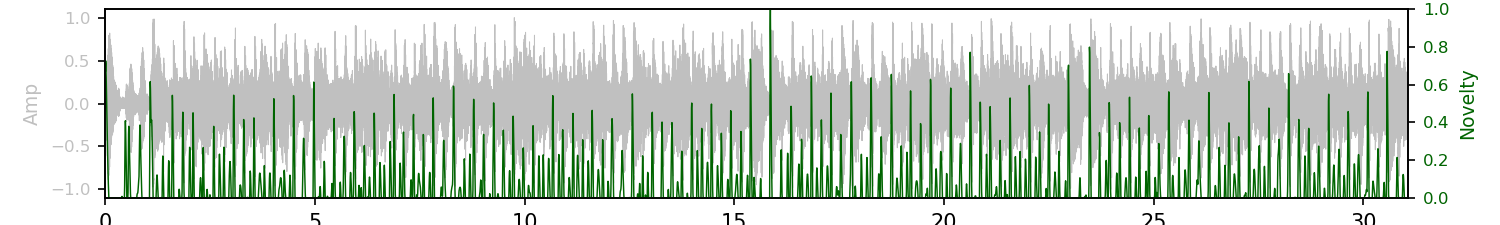
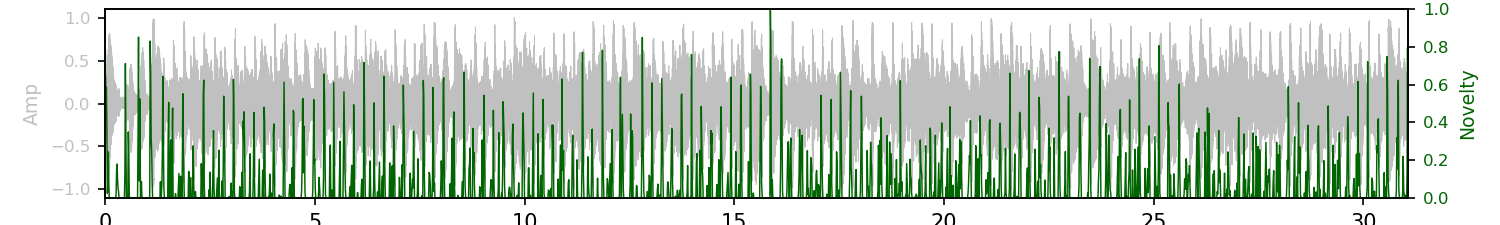
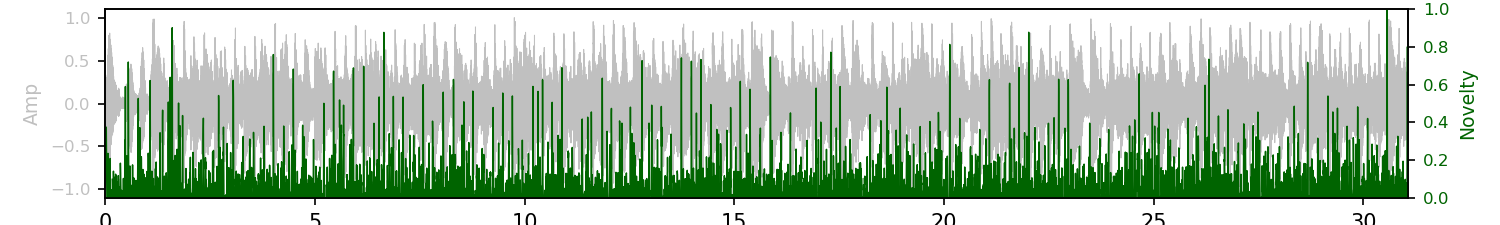
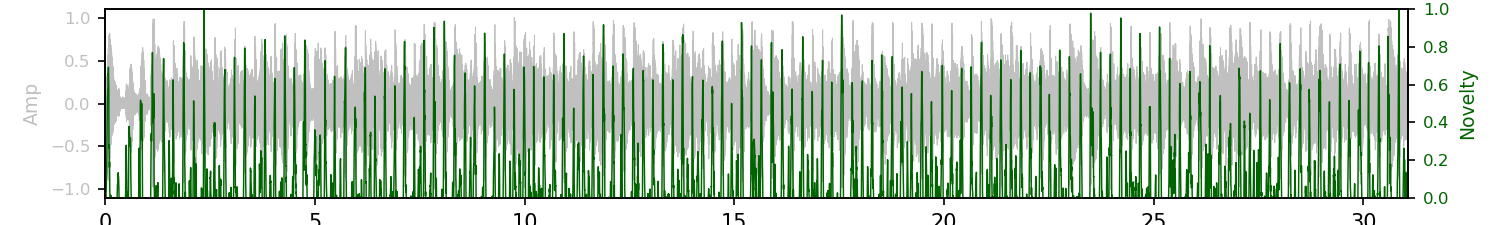

In [5]:
fig1, ax1 = plt.subplots(figsize=(10, 1.5))
ax1.plot(t_wav, x, color="#c0c0c0", linewidth=0.5)
ax1.set_ylabel("Amp", color="#c0c0c0", fontsize=9)
ax1.set_xlabel("Time (s)", fontsize=9)
ax1.set_xlim(0, duration_s)
ax1.tick_params(axis="y", labelcolor="#c0c0c0", labelsize=8)
ax2 = ax1.twinx()
ax2.plot(np.arange(len(novelty_eng)) / Fs_eng, novelty_eng, color="darkgreen", linewidth=0.7)
ax2.set_ylabel("Novelty", color="darkgreen", fontsize=9)
ax2.set_ylim(0, 1)
ax2.tick_params(axis="y", labelcolor="darkgreen", labelsize=8)
ax2.set_xlim(0, duration_s)
ax1.set_title("Energy", fontsize=10)
plt.tight_layout()
fig1.subplots_adjust(top=0.96, bottom=0.12)
h_eng = build_audio_with_cursor_html(x, sr, fig=fig1, ax=ax1, close_fig=True)

fig2, ax2 = plt.subplots(figsize=(10, 1.5))
ax2.plot(t_wav, x, color="#c0c0c0", linewidth=0.5)
ax2.set_ylabel("Amp", color="#c0c0c0", fontsize=9)
ax2.set_xlabel("Time (s)", fontsize=9)
ax2.set_xlim(0, duration_s)
ax2.tick_params(axis="y", labelcolor="#c0c0c0", labelsize=8)
ax2b = ax2.twinx()
ax2b.plot(np.arange(len(novelty_spec)) / Fs_spec, novelty_spec, color="darkgreen", linewidth=0.7)
ax2b.set_ylabel("Novelty", color="darkgreen", fontsize=9)
ax2b.set_ylim(0, 1)
ax2b.tick_params(axis="y", labelcolor="darkgreen", labelsize=8)
ax2b.set_xlim(0, duration_s)
ax2.set_title("Spectral", fontsize=10)
plt.tight_layout()
fig2.subplots_adjust(top=0.96, bottom=0.12)
h_spec = build_audio_with_cursor_html(x, sr, fig=fig2, ax=ax2, close_fig=True)

fig3, ax3 = plt.subplots(figsize=(10, 1.5))
ax3.plot(t_wav, x, color="#c0c0c0", linewidth=0.5)
ax3.set_ylabel("Amp", color="#c0c0c0", fontsize=9)
ax3.set_xlabel("Time (s)", fontsize=9)
ax3.set_xlim(0, duration_s)
ax3.tick_params(axis="y", labelcolor="#c0c0c0", labelsize=8)
ax3b = ax3.twinx()
ax3b.plot(np.arange(len(novelty_phase)) / Fs_phase, novelty_phase, color="darkgreen", linewidth=0.7)
ax3b.set_ylabel("Novelty", color="darkgreen", fontsize=9)
ax3b.set_ylim(0, 1)
ax3b.tick_params(axis="y", labelcolor="darkgreen", labelsize=8)
ax3b.set_xlim(0, duration_s)
ax3.set_title("Phase", fontsize=10)
plt.tight_layout()
fig3.subplots_adjust(top=0.96, bottom=0.12)
h_phase = build_audio_with_cursor_html(x, sr, fig=fig3, ax=ax3, close_fig=True)

fig4, ax4 = plt.subplots(figsize=(10, 1.5))
ax4.plot(t_wav, x, color="#c0c0c0", linewidth=0.5)
ax4.set_ylabel("Amp", color="#c0c0c0", fontsize=9)
ax4.set_xlabel("Time (s)", fontsize=9)
ax4.set_xlim(0, duration_s)
ax4.tick_params(axis="y", labelcolor="#c0c0c0", labelsize=8)
ax4b = ax4.twinx()
ax4b.plot(np.arange(len(novelty_complex)) / Fs_complex, novelty_complex, color="darkgreen", linewidth=0.7)
ax4b.set_ylabel("Novelty", color="darkgreen", fontsize=9)
ax4b.set_ylim(0, 1)
ax4b.tick_params(axis="y", labelcolor="darkgreen", labelsize=8)
ax4b.set_xlim(0, duration_s)
ax4.set_title("Complex", fontsize=10)
plt.tight_layout()
fig4.subplots_adjust(top=0.96, bottom=0.12)
h_complex = build_audio_with_cursor_html(x, sr, fig=fig4, ax=ax4, close_fig=True)

# Display all four players in one column (stacked)
wrapper = '<div style="display:flex; flex-direction:column; gap:1rem;">'
wrapper += '<div>' + h_eng.html + '</div>'
wrapper += '<div>' + h_spec.html + '</div>'
wrapper += '<div>' + h_phase.html + '</div>'
wrapper += '<div>' + h_complex.html + '</div>'
wrapper += '</div>'
display(HTML(wrapper))